# Bibliotecas

In [1]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays
using DataFrames
using Printf
using Random

## Seed de aleatoriedade

In [2]:
seed = 42
Random.seed!(seed)
print("Seed ", seed, " fixada para testes. Comentar linha para retormar aleatoriedade")

Seed 42 fixada para testes. Comentar linha para retormar aleatoriedade

# Base

In [3]:
function ϕ(a::Int64)::Function
    if a == 1
        return (ξ₁::Float64, ξ₂::Float64) -> (1.0-ξ₁)*(1.0-ξ₂)/4.0
        
    elseif a == 2
        return (ξ₁::Float64, ξ₂::Float64) -> (1.0+ξ₁)*(1.0-ξ₂)/4.0
        
    elseif a == 3
        return (ξ₁::Float64, ξ₂::Float64) -> (1.0+ξ₁)*(1.0+ξ₂)/4.0
        
    elseif a == 4
        return (ξ₁::Float64, ξ₂::Float64) -> (1.0-ξ₁)*(1.0+ξ₂)/4.0
        
    end
end

function ∂ϕ(variable::Int64, a::Int64)::Function
    if variable == 1
        if a == 1
            return (ξ₁::Float64, ξ₂::Float64) -> -(1.0-ξ₂)/4.0
        elseif a == 2
            return (ξ₁::Float64, ξ₂::Float64) ->  (1.0-ξ₂)/4.0
        elseif a == 3
            return (ξ₁::Float64, ξ₂::Float64) ->  (1.0+ξ₂)/4.0
        elseif a == 4
            return (ξ₁::Float64, ξ₂::Float64) -> -(1.0+ξ₂)/4.0
        end
        
    elseif variable == 2
        if a == 1
            return (ξ₁::Float64, ξ₂::Float64) -> -(1.0-ξ₁)/4.0
        elseif a == 2
            return (ξ₁::Float64, ξ₂::Float64) -> -(1.0+ξ₁)/4.0
        elseif a == 3
            return (ξ₁::Float64, ξ₂::Float64) ->  (1.0+ξ₁)/4.0
        elseif a == 4
            return (ξ₁::Float64, ξ₂::Float64) ->  (1.0-ξ₁)/4.0
        end
        
    end
end

∂ϕ (generic function with 1 method)

# Funções auxiliares

In [4]:
function plot_error_curves(h::Vector{Float64}, erros::Vector{Float64})
   plot(h, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
   display(plot!(h, h.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)) 
end

plot_error_curves (generic function with 1 method)

In [5]:
function malha2D(Nx1, Nx2)
    # Define o comprimento da base (h₁) e altura (h₂) de cada elemento retangular Ωᵉ
    h₁, h₂ = 1 / Nx1, 1 / Nx2

    # Define a discretização em x₁ e x₂
    x₁ = collect(0:h₁:1)
    x₂ = collect(0:h₂:1)

    # Define as coordenadas de cada nó da malha
    X₁ = [x₁[i] for i in 1:Nx1+1, j in 1:Nx2+1]
    X₂ = [x₂[j] for i in 1:Nx1+1, j in 1:Nx2+1]

    return X₁, X₂, h₁, h₂
end

malha2D (generic function with 1 method)

In [6]:
function malha2D_adiciona_ruido!(X₁::Matrix{Float64}, X₂::Matrix{Float64},
                                 h₁::Float64, h₂::Float64)
    # Verifica se as matrizes têm a mesma dimensão
    @assert size(X₁) == size(X₂) "X₁ e X₂ devem ter as mesmas dimensões"
    
    # Verifica se a malha é suficientemente grande para ter nós internos
    if size(X₁, 1) > 2 && size(X₁, 2) > 2
        # Define os limites do ruído
        ruído_limite₁, ruído_limite₂ = h₁ / 4, h₂ / 4
        
        # Aplica ruído uniforme aos nós internos
        X₁[2:end-1, 2:end-1] .+= ruído_limite₁ * 
                                (rand(Float64, size(X₁[2:end-1,2:end-1])) .- 0.5) * 2
        X₂[2:end-1, 2:end-1] .+= ruído_limite₂ * 
                                (rand(Float64, size(X₂[2:end-1,2:end-1])) .- 0.5) * 2
    end
end

malha2D_adiciona_ruido! (generic function with 1 method)

# Funções de Montagem auxiliar (EQ e LG)

In [7]:
function monta_EQ(Nx1::Int64, Nx2::Int64)::Tuple{Int64, Vector{Int64}}
    flat = Iterators.flatten
    
    m = (Nx1-1)*(Nx2-1)
    get_EQ_line = (line_index::Int64) -> [m+1, line_index*(Nx1-1)+1:((line_index+1)*(Nx1-1)), m+1]   
    
    boundary_line = fill(m+1, Nx1+1)
    mid_matrix = [boundary_line, flat(flat.(get_EQ_line.(0:Nx2-2))), boundary_line]
    flat_matrix = collect(flat(mid_matrix))::Vector{Int64}
    
    #display(transpose(reshape(flat_matrix, (Nx1+1, Nx2+1))))
    return (m, flat_matrix)
end

monta_EQ (generic function with 1 method)

In [8]:
function monta_LG(Nx1::Int64, Nx2::Int64)::Matrix{Int64}
    vec_line = (line::Int64) -> (Nx1+1)*line .+ (1:Nx1)
    vec = vec_line.(0:Nx2-1)
    
    get_LG_column = (corner_index::Int64) -> [corner_index; corner_index + 1;
                                              corner_index + Nx1+2; corner_index + Nx1+1]
    
    flat_matrix = Iterators.flatten(map(x -> get_LG_column.(x), vec))
    matrix = reshape(collect(Iterators.flatten(flat_matrix)), (4, Nx1*Nx2))
    
    return matrix
end

monta_LG (generic function with 1 method)

### Testes de Montagem

#### Teste 1

In [9]:
monta_LG(4, 4)

4×16 Matrix{Int64}:
 1  2  3   4   6   7   8   9  11  12  13  14  16  17  18  19
 2  3  4   5   7   8   9  10  12  13  14  15  17  18  19  20
 7  8  9  10  12  13  14  15  17  18  19  20  22  23  24  25
 6  7  8   9  11  12  13  14  16  17  18  19  21  22  23  24

#### Teste 2

In [10]:
monta_EQ(4, 3)

(6, [7, 7, 7, 7, 7, 7, 1, 2, 3, 7, 7, 4, 5, 6, 7, 7, 7, 7, 7, 7])

#### Teste 3

In [11]:
monta_EQ(4, 4)

(9, [10, 10, 10, 10, 10, 10, 1, 2, 3, 10  …  10, 7, 8, 9, 10, 10, 10, 10, 10, 10])

# Caso quadrado

## Funções de mapping

In [12]:
function mapper_to_x(h::Float64, pᵉ::Float64)::Function
    return (ξ::Float64) -> (h/2)*(ξ+1) + pᵉ
end

mapper_to_x (generic function with 1 method)

## Quadraturas

In [13]:
function quadratura_phis_K_2D(f1::Function, f2::Function, P::Vector{Float64}, W::Vector{Float64})::Float64
    quadratura = 0.0
    
    for (ξ₁, w₁) in zip(P, W)
        for (ξ₂, w₂) in zip(P, W)
            quadratura += (w₁*w₂) * (f1(ξ₁, ξ₂) * f2(ξ₁, ξ₂))
        end
    end
    
    return quadratura
end

function quadratura_F_2D(f1::Function, f2::Function, h::Vector{Float64}, pᵉ::Vector{Float64}, P::Vector{Float64}, W::Vector{Float64})::Float64
    quadratura = 0.0
    
    ξ_to_x1 = mapper_to_x(h[1], pᵉ[1])
    ξ_to_x2 = mapper_to_x(h[2], pᵉ[2])
    
    for (ξ₁, w₁) in zip(P, W)
        for (ξ₂, w₂) in zip(P, W)            
            quadratura += (w₁*w₂) * f1(ξ_to_x1(ξ₁), ξ_to_x2(ξ₂)) * f2(ξ₁, ξ₂)
        end
    end
    
    return quadratura
end

quadratura_F_2D (generic function with 1 method)

## Funções de Montagem local (K e F)

In [14]:
function monta_F_local_2D(f::Function, h::Vector{Float64}, pᵉ::Vector{Float64}, P::Vector{Float64}, W::Vector{Float64})
    F_local = zeros(4)
    
    for a in 1:4
         F_local[a] = (h[1]*h[2]/4) * quadratura_F_2D(f, ϕ(a), h, pᵉ, P, W)
    end
    
    return F_local    
end

monta_F_local_2D (generic function with 1 method)

In [15]:
function monta_K_local_2D(α::Float64, β::Float64, h::Vector{Float64}, P::Vector{Float64}, W::Vector{Float64})::Matrix{Float64}
    K_local = zeros(4, 4)
    
    for a in 1:4
        for b in 1:4
            K_local[a, b] = (α*( h[2]/h[1])   ) * quadratura_phis_K_2D(∂ϕ(1,b), ∂ϕ(1,a), P, W) +
                            (α*( h[1]/h[2])   ) * quadratura_phis_K_2D(∂ϕ(2,b), ∂ϕ(2,a), P, W) +
                            (β*((h[1]*h[2])/4)) * quadratura_phis_K_2D( ϕ(  b),  ϕ(  a), P, W)
        end
    end
    
    return K_local
end

monta_K_local_2D (generic function with 1 method)

### Testes de Montagem

#### Teste 1

In [16]:
h = [1/4; 1/4]
α = 6.0
β = 0.0

f = (x1::Float64, x2::Float64) -> 4/(h[1]*h[2])
pᵉ = [0.0; 0.0]
P, W = legendre(2)

display(monta_F_local_2D(f, h, pᵉ, P, W))
display(monta_K_local_2D(α, β, h, P, W))

4-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0

4×4 Matrix{Float64}:
  4.0  -1.0  -2.0  -1.0
 -1.0   4.0  -1.0  -2.0
 -2.0  -1.0   4.0  -1.0
 -1.0  -2.0  -1.0   4.0

#### Teste 2

In [17]:
h = [1/4; 1/4]
α = 0.0
β = (9.0 * 4.0)/ (h[1] * h[2])

f = (x1::Float64, x2::Float64) -> (16/(h[1]*h[2])^2)*9*x1*x2
pᵉ = [0.0; 0.0]
P, W = legendre(2)

display(monta_F_local_2D(f, h, pᵉ, P, W))
display(monta_K_local_2D(α, β, h, P, W))

4-element Vector{Float64}:
  4.0
  8.0
 16.0
  8.0

4×4 Matrix{Float64}:
 4.0  2.0  1.0  2.0
 2.0  4.0  2.0  1.0
 1.0  2.0  4.0  2.0
 2.0  1.0  2.0  4.0

## Funções de Montagem global (K e F)

In [18]:
function monta_F_global_2D(f::Function, Nx1::Int64, Nx2::Int64, m::Int64, EQoLG::Matrix{Int64})::Vector{Float64}
    h = [1/Nx1; 1/Nx2]    
    F_global = zeros(m+1)
    
    P, W = legendre(5)
    
    for j in 1:Nx2
        for i in 1:Nx1
            pᵉ = [(i-1)*h[1]; (j-1)*h[2]]
            e = (j-1)*Nx1 + i
            F_local = monta_F_local_2D(f, h, pᵉ, P, W)
            
            for a in 1:4
                index = EQoLG[a, e]
                F_global[index] += F_local[a]
            end
        end
    end
    
    return F_global[1:m]
end


monta_F_global_2D (generic function with 1 method)

In [19]:
function monta_K_global_2D(α::Float64, β::Float64, Nx1::Int64, Nx2::Int64, m::Int64, EQoLG::Matrix{Int64})::SparseMatrixCSC{Float64}
    h = [1/Nx1; 1/Nx2]    
    P, W = legendre(2)
    
    K_global = spzeros(m+1, m+1)   
    K_local = monta_K_local_2D(α, β, h, P, W)
    
    for j in 1:Nx2
        for i in 1:Nx1
            e = (j-1)*Nx1 + i
            
            for b in 1:4
                for a in 1:4
                    index_i = EQoLG[a, e]
                    index_j = EQoLG[b, e]
                    
                    K_global[index_i, index_j] += K_local[a, b]
                end
            end
        end
    end
    
    return K_global[1:m, 1:m]
end

monta_K_global_2D (generic function with 1 method)

### Testes de Montagem

#### Teste 1

In [20]:
Nx1 = 4
Nx2 = 4

h = [1/Nx1; 1/Nx2]
f = (x1::Float64, x2::Float64) -> 4/(h[1]*h[2])

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

#display(EQ)
#display(LG)
#display(EQ[LG])
#display(transpose(reshape(EQ, (Nx1+1, Nx2+1))))

monta_F_global_2D(f, Nx1, Nx2, m, EQ[LG])

9-element Vector{Float64}:
 3.999999999999999
 3.999999999999999
 3.999999999999999
 3.999999999999999
 3.999999999999999
 3.999999999999999
 3.999999999999999
 3.999999999999999
 3.999999999999999

#### Teste 2

In [21]:
Nx1 = 4
Nx2 = 4

h = [1/Nx1; 1/Nx2]
f = (x1::Float64, x2::Float64) -> (16*9*x1*x2)/(h[1]*h[2])^2

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

monta_F_global_2D(f, Nx1, Nx2, m, EQ[LG])

9-element Vector{Float64}:
  143.99999999999994
  287.9999999999999
  431.9999999999998
  287.9999999999999
  575.9999999999999
  863.9999999999995
  431.9999999999998
  863.9999999999997
 1295.9999999999998

#### Teste 3

In [22]:
α = 1.0
β = 1.0

Nx1 = 4
Nx2 = 3

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

monta_K_global_2D(α, β, Nx1, Nx2, m, EQ[LG])

6×6 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  2.81481    -0.62963      ⋅         -0.0462963  -0.344907     ⋅ 
 -0.62963     2.81481    -0.62963    -0.344907   -0.0462963  -0.344907
   ⋅         -0.62963     2.81481      ⋅         -0.344907   -0.0462963
 -0.0462963  -0.344907     ⋅          2.81481    -0.62963      ⋅ 
 -0.344907   -0.0462963  -0.344907   -0.62963     2.81481    -0.62963
   ⋅         -0.344907   -0.0462963    ⋅         -0.62963     2.81481

## Cálculo de Erro

In [23]:
function erro_norma_L2_2D(u::Function, c_::Vector{Float64}, Nx1::Int64, Nx2::Int64, EQoLG::Matrix{Int64})::Float64
    h = [1/Nx1; 1/Nx2]
    
    ne = Nx1 * Nx2
    P, W = legendre(5)
    
    erro = 0.0    
    
    for j in 1:Nx2
        for i in 1:Nx1
            e = (j-1)*Nx1 + i
            pᵉ = [(i-1)*h[1]; (j-1)*h[2]]
            
            ξ_to_x1 = mapper_to_x(h[1], pᵉ[1])
            ξ_to_x2 = mapper_to_x(h[2], pᵉ[2])
            
            quadratura = 0.0

            for (ξ₁, w₁) in zip(P, W)
                for (ξ₂, w₂) in zip(P, W)
                    uₕᵉ_ξ = 0.0

                    for a in 1:4
                        index = EQoLG[a, e]
                        uₕᵉ_ξ += c_[index]*(ϕ(a)(ξ₁, ξ₂))
                    end

                    x1 = ξ_to_x1(ξ₁)
                    x2 = ξ_to_x2(ξ₂)

                    quadratura += (w₁*w₂) * abs(u(x1, x2) - uₕᵉ_ξ)^2
                end
            end

            erro += quadratura
        end
    end    
    
    return sqrt((h[1]*h[2]/4) * erro)
end

erro_norma_L2_2D (generic function with 1 method)

### Teste de cálculo

In [24]:
α = 1.0
β = 1.0
f = (x₁::Float64, x₂::Float64) -> (2*α*π^2+β) * sin(π*x₁) * sin(π*x₂)
u = (x₁::Float64, x₂::Float64) -> sin(π*x₁) * sin(π*x₂)

Nx1 = 8 
Nx2 = 8

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)
EQoLG = EQ[LG]

c = monta_K_global_2D(α, β, Nx1, Nx2, m, EQoLG) \ monta_F_global_2D(f, Nx1, Nx2, m, EQoLG)
c_ = [c; 0]
display(c)

erro = erro_norma_L2_2D(u, c_, Nx1, Nx2, EQoLG)
display(erro)

49-element Vector{Float64}:
 0.14842938111206438
 0.2742617344655072
 0.3583402249353907
 0.3878646645210889
 0.3583402249353907
 0.2742617344655072
 0.14842938111206438
 0.2742617344655073
 0.5067696060474551
 0.6621263989865962
 0.7166804498707814
 0.6621263989865962
 0.5067696060474551
 ⋮
 0.6621263989865963
 0.7166804498707816
 0.6621263989865964
 0.5067696060474555
 0.27426173446550745
 0.1484293811120644
 0.2742617344655074
 0.3583402249353909
 0.38786466452108903
 0.3583402249353909
 0.2742617344655075
 0.14842938111206447

0.007348142187149791

## Estudo de Convergência

In [25]:
function estudo_de_convergencia(α::Float64, β::Float64, f::Function, u::Function, n_testes::Int64)::Matrix{Float64}
    
    resultado = zeros(n_testes, 2)
    
    for tamanho in 2:n_testes+1
        Nx1 = 2^tamanho
        Nx2 = 2^tamanho
        h = [1/Nx1, 1/Nx2]
        
        m, EQ = monta_EQ(Nx1, Nx2)
        LG = monta_LG(Nx1, Nx2)
        EQoLG = EQ[LG]
        
        K = monta_K_global_2D(α, β, Nx1, Nx2, m, EQoLG)
        F = monta_F_global_2D(f, Nx1, Nx2, m, EQoLG)
        
        c = K \ F
        c_ = [c; 0]
        
        erro = erro_norma_L2_2D(u, c_, Nx1, Nx2, EQoLG)
        
        resultado[tamanho-1, 1] = sqrt(h[1]^2 + h[2]^2)
        resultado[tamanho-1, 2] = erro
    end
    
    return resultado
end

estudo_de_convergencia (generic function with 1 method)

In [26]:
α = 1.0
β = 1.0
f = (x₁::Float64, x₂::Float64) -> (2*α*π^2+β) * sin(π*x₁) * sin(π*x₂)
u = (x₁::Float64, x₂::Float64) -> sin(π*x₁) * sin(π*x₂)
n_testes = 7

resultado_convergencia = estudo_de_convergencia(α, β, f, u, n_testes)

7×2 Matrix{Float64}:
 0.353553    0.0294644
 0.176777    0.00734814
 0.0883883   0.00183603
 0.0441942   0.000458945
 0.0220971   0.000114733
 0.0110485   2.86829e-5
 0.00552427  7.17071e-6

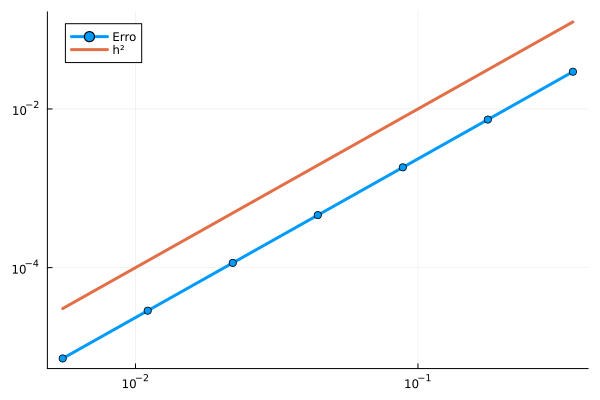

In [27]:
plot_error_curves(resultado_convergencia[: ,:1], resultado_convergencia[: ,:2])

# Caso quadrilátero convexo com lados não-paralelos

## Funções de mapping

In [28]:
function mapper_to_x_generic(Xᵉ_a::Vector{Float64})::Function
    return (ξ₁::Float64, ξ₂::Float64)-> Xᵉ_a ⋅ map(f -> f(ξ₁, ξ₂), ϕ.(1:length(Xᵉ_a)))
end

function derivative_vector_applied(Xᵉ_a::Vector{Float64}, variable::Int64)::Function
    return (ξ₁::Float64, ξ₂::Float64)-> Xᵉ_a ⋅ map(f -> f(ξ₁, ξ₂), ∂ϕ.(variable, 1:length(Xᵉ_a)))
end

derivative_vector_applied (generic function with 1 method)

## Quadraturas

In [29]:
function quadratura_F_local_quadrilatero(f::Function, ϕₐ::Function, X1e::Vector{Float64}, X2e::Vector{Float64}, P::Vector{Float64}, W::Vector{Float64})
    quadratura = 0.0
    
    ξ_to_x1 = mapper_to_x_generic(X1e)
    ξ_to_x2 = mapper_to_x_generic(X2e)
    
    for (ξ₁, w₁) in zip(P, W)
        for (ξ₂, w₂) in zip(P, W)
            dx1_dξ1 = derivative_vector_applied(X1e, 1)(ξ₁, ξ₂)
            dx2_dξ2 = derivative_vector_applied(X2e, 2)(ξ₁, ξ₂)
            dx1_dξ2 = derivative_vector_applied(X1e, 2)(ξ₁, ξ₂)
            dx2_dξ1 = derivative_vector_applied(X2e, 1)(ξ₁, ξ₂)
            
            J_ξ = dx1_dξ1 * dx2_dξ2 - dx1_dξ2 * dx2_dξ1            
            quadratura += (w₁*w₂) * f(ξ_to_x1(ξ₁, ξ₂), ξ_to_x2(ξ₁, ξ₂)) * ϕₐ(ξ₁, ξ₂) * J_ξ
                          
        end
    end
    
    return quadratura
end

quadratura_F_local_quadrilatero (generic function with 1 method)

In [30]:
function quadratura_K_local_quadrilatero(a::Int64, b::Int64, α::Float64, β::Float64, X1e::Vector{Float64}, X2e::Vector{Float64}, P::Vector{Float64}, W::Vector{Float64})::Float64
    
    quadratura_α = 0.0
    quadratura_β = 0.0
    
    for (ξ₁, w₁) in zip(P, W)
        for (ξ₂, w₂) in zip(P, W)
            dx1_dξ1 = derivative_vector_applied(X1e, 1)(ξ₁, ξ₂)
            dx2_dξ2 = derivative_vector_applied(X2e, 2)(ξ₁, ξ₂)
            dx1_dξ2 = derivative_vector_applied(X1e, 2)(ξ₁, ξ₂)
            dx2_dξ1 = derivative_vector_applied(X2e, 1)(ξ₁, ξ₂)
            
            HTH_11 = (dx2_dξ2)^2 + (dx1_dξ2)^2
            HTH_12 = -(dx2_dξ2 * dx2_dξ1) - (dx1_dξ2 * dx1_dξ1)
            HTH_21 = -(dx2_dξ1 * dx2_dξ2) - (dx1_dξ1 * dx1_dξ2)
            HTH_22 = (dx2_dξ1)^2 + (dx1_dξ1)^2
            
            termo1 = ∂ϕ(1, b)(ξ₁, ξ₂) * (HTH_11 * ∂ϕ(1, a)(ξ₁, ξ₂) + HTH_12 * ∂ϕ(2, a)(ξ₁, ξ₂)) 
            termo2 = ∂ϕ(2, b)(ξ₁, ξ₂) * (HTH_21 * ∂ϕ(1, a)(ξ₁, ξ₂) + HTH_22 * ∂ϕ(2, a)(ξ₁, ξ₂))
            
            J_ξ = (dx1_dξ1 * dx2_dξ2) - (dx1_dξ2 * dx2_dξ1)
            
            quadratura_α += (w₁ * w₂) * (termo1 + termo2) * (1/J_ξ)
            quadratura_β += (w₁ * w₂) * ϕ(b)(ξ₁, ξ₂) * ϕ(a)(ξ₁, ξ₂) * J_ξ
            
        end
    end
    
    quadratura_α *= α    
    quadratura_β *= β
    
    return quadratura_α + quadratura_β     
end

quadratura_K_local_quadrilatero (generic function with 1 method)

## Funções de Montagem local (K e F)

In [31]:
function monta_F_local_quadrilatero(f::Function, X1e::Vector{Float64}, X2e::Vector{Float64}, P::Vector{Float64}, W::Vector{Float64})
    F_local = zeros(4)
    
    for a in 1:4
         F_local[a] = quadratura_F_local_quadrilatero(f, ϕ(a), X1e, X2e, P, W)
    end
    
    return F_local    
end

monta_F_local_quadrilatero (generic function with 1 method)

In [32]:
function monta_K_local_quadrilatero(α::Float64, β::Float64, X1e::Vector{Float64}, X2e::Vector{Float64}, P::Vector{Float64}, W::Vector{Float64})::Matrix{Float64}    
    Kᵉ = zeros(4, 4)
    
    for b in 1:4
        for a in 1:4
            Kᵉ[a, b] = quadratura_K_local_quadrilatero(a, b, α, β, X1e, X2e, P, W)
        end
    end
    
    return Kᵉ
end

monta_K_local_quadrilatero (generic function with 1 method)

### Testes de Montagem

#### Teste 1

In [33]:
α = 6.0
β = 0.0

f = (x1::Float64, x2::Float64) -> 4/(0.25*0.25)
X1e = [0.0, 0.25, 0.25, 0.0]
X2e = [0.0, 0.0, 0.25, 0.25]

P, W = legendre(5)

monta_F_local_quadrilatero(f, X1e, X2e, P, W)
monta_K_local_quadrilatero(α, β, X1e, X2e, P, W)

4×4 Matrix{Float64}:
  4.0  -1.0  -2.0  -1.0
 -1.0   4.0  -1.0  -2.0
 -2.0  -1.0   4.0  -1.0
 -1.0  -2.0  -1.0   4.0

In [34]:
α = 0.0
β = 576.0

f = (x1::Float64, x2::Float64) -> (16*9*x1*x2)/(0.25*0.25)^2
X1e = [0.0, 0.25, 0.25, 0.0]
X2e = [0.0, 0.0, 0.25, 0.25]
P, W = legendre(5)

monta_F_local_quadrilatero(f, X1e, X2e, P, W)
monta_K_local_quadrilatero(α, β, X1e, X2e, P, W)

4×4 Matrix{Float64}:
 4.0  2.0  1.0  2.0
 2.0  4.0  2.0  1.0
 1.0  2.0  4.0  2.0
 2.0  1.0  2.0  4.0

In [35]:
α = 1.0
β = 1.0

f = (x1::Float64, x2::Float64) -> x1 + x2
X1e = [0.0, 2.0, 3.0, 1.0]
X2e = [0.0, 0.0, 1.0, 1.0]
P, W = legendre(5)

monta_F_local_quadrilatero(f, X1e, X2e, P, W)
monta_K_local_quadrilatero(α, β, X1e, X2e, P, W)

4×4 Matrix{Float64}:
  0.722222    0.111111   0.0555556  -0.388889
  0.111111    1.72222   -0.388889   -0.944444
  0.0555556  -0.388889   0.722222    0.111111
 -0.388889   -0.944444   0.111111    1.72222

## Funções de Montagem global (K e F)

In [36]:
function monta_F_global_quadrilatero(f::Function, X₁::AbstractArray{Float64}, X₂::AbstractArray{Float64}, m::Int64, EQ::Vector{Int64}, LG::Matrix{Int64})::Vector{Float64}
    F_global = zeros(m+1)
    ne = size(LG)[2]
    EQoLG = EQ[LG]
        
    P, W = legendre(5)
    for e in 1:ne
        X1e = X₁[LG[:, e]]
        X2e = X₂[LG[:, e]]
        
        F_local = monta_F_local_quadrilatero(f, X1e, X2e, P, W)
        
        for a in 1:4
            index = EQoLG[a, e]
            F_global[index] += F_local[a]
        end
    end
        
    return F_global[1:m]
end

monta_F_global_quadrilatero (generic function with 1 method)

In [37]:
function monta_K_global_quadrilatero(α::Float64, β::Float64, X₁::AbstractArray{Float64}, X₂::AbstractArray{Float64}, m::Int64, EQ::Vector{Int64}, LG::Matrix{Int64})::SparseMatrixCSC{Float64}
    K_global = spzeros(m+1, m+1)
    EQoLG = EQ[LG]
    
    P, W = legendre(5)
    ne = size(LG)[2]
    
    for e in 1:ne        
        X1e = X₁[LG[:, e]]
        X2e = X₂[LG[:, e]]
        
        K_local = monta_K_local_quadrilatero(α, β, X1e, X2e, P, W)
        for b in 1:4
            for a in 1:4
                index_i = EQoLG[a, e]
                index_j = EQoLG[b, e]
                
                K_global[index_i, index_j] += K_local[a, b]
            end
        end
    end
    
    return K_global[1:m, 1:m]    
end

monta_K_global_quadrilatero (generic function with 1 method)

### Testes de Montagem - F

#### Teste 1

In [38]:
Nx1 = 4
Nx2 = 3

h = [1/Nx1; 1/Nx2]
f = (x1::Float64, x2::Float64) -> 4/(h[1]*h[2])

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

X1, X2, h1, h2 = malha2D(Nx1, Nx2)

monta_F_global_quadrilatero(f, X1, X2, m, EQ, LG)

6-element Vector{Float64}:
 3.999999999999999
 3.999999999999999
 3.999999999999999
 3.9999999999999996
 3.9999999999999996
 3.999999999999999

#### Teste 2

In [39]:
Nx1 = 4
Nx2 = 4

h = [1/Nx1; 1/Nx2]
f = (x1::Float64, x2::Float64) -> (16*9*x1*x2)/(h[1]*h[2])^2

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

X1, X2, h1, h2 = malha2D(Nx1, Nx2)

monta_F_global_quadrilatero(f, X1, X2, m, EQ, LG)

9-element Vector{Float64}:
  143.99999999999994
  287.99999999999994
  431.99999999999983
  287.99999999999994
  576.0
  863.9999999999998
  431.99999999999983
  863.9999999999998
 1296.0

#### Teste 3

In [40]:
Nx1 = 4
Nx2 = 3

f = (x1::Float64, x2::Float64) -> x1 + x2

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

X1, X2, h1, h2 = malha2D(Nx1, Nx2)

monta_F_global_quadrilatero(f, X1, X2, m, EQ, LG)

6-element Vector{Float64}:
 0.04861111111111109
 0.06944444444444442
 0.09027777777777776
 0.07638888888888887
 0.0972222222222222
 0.11805555555555552

#### Teste 4

In [41]:
Nx1 = 4
Nx2 = 3

f = (x1::Float64, x2::Float64) -> x1 + x2

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

X1, X2, h1, h2 = malha2D(Nx1, Nx2)
malha2D_adiciona_ruido!(X1, X2, h1, h2)

monta_F_global_quadrilatero(f, X1, X2, m, EQ, LG)

6-element Vector{Float64}:
 0.047603316256427886
 0.0685848331877617
 0.09299899556951925
 0.07729379019471166
 0.08630556638050947
 0.11514211312826136

### Testes de Montagem - K

#### Teste 1

In [42]:
α = 1.0
β = 1.0

Nx1 = 4
Nx2 = 3

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

X1, X2, h1, h2 = malha2D(Nx1, Nx2)

monta_K_global_quadrilatero(α, β, X1, X2, m, EQ, LG)

6×6 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  2.81481    -0.62963      ⋅         -0.0462963  -0.344907     ⋅ 
 -0.62963     2.81481    -0.62963    -0.344907   -0.0462963  -0.344907
   ⋅         -0.62963     2.81481      ⋅         -0.344907   -0.0462963
 -0.0462963  -0.344907     ⋅          2.81481    -0.62963      ⋅ 
 -0.344907   -0.0462963  -0.344907   -0.62963     2.81481    -0.62963
   ⋅         -0.344907   -0.0462963    ⋅         -0.62963     2.81481

#### Teste 2

In [43]:
α = 1.0
β = 1.0

Nx1 = 4
Nx2 = 3

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)

X1, X2, h1, h2 = malha2D(Nx1, Nx2)
malha2D_adiciona_ruido!(X1, X2, h1, h2)

monta_K_global_quadrilatero(α, β, X1, X2, m, EQ, LG)

6×6 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  2.88092    -0.613458    ⋅          0.0381134  -0.40725     ⋅ 
 -0.613458    2.75984   -0.499622   -0.277955   -0.188666  -0.375015
   ⋅         -0.499622   2.8879       ⋅         -0.327087   0.0851113
  0.0381134  -0.277955    ⋅          2.91656    -0.563437    ⋅ 
 -0.40725    -0.188666  -0.327087   -0.563437    2.8353    -0.719416
   ⋅         -0.375015   0.0851113    ⋅         -0.719416   2.94773

## Cálculo do Erro

In [44]:
function erro_norma_L2_quadrilatero(u::Function, c̄::Vector{Float64}, X₁::AbstractArray{Float64}, X₂::AbstractArray{Float64}, EQ::Vector{Int64}, LG::Matrix{Int64})::Float64
    quadratura_erro = 0.0
    
    ne = size(LG)[2]
    P, W = legendre(5)
    
    EQoLG = EQ[LG]
    for e in 1:ne
        X1e = X₁[LG[:, e]]
        X2e = X₂[LG[:, e]]         
        ξ_to_x1 = mapper_to_x_generic(X1e)
        ξ_to_x2 = mapper_to_x_generic(X2e)
        
        for (ξ₁, w₁) in zip(P, W)
            for (ξ₂, w₂) in zip(P, W)
                
                u_in_x_from_ξ = u(ξ_to_x1(ξ₁, ξ₂), ξ_to_x2(ξ₁, ξ₂))
                uh_in_ξ = 0

                for a in 1:4
                    uh_in_ξ += c̄[EQoLG[a, e]] * ϕ(a)(ξ₁, ξ₂) 
                end
                
                dx1_dξ1 = derivative_vector_applied(X1e, 1)(ξ₁, ξ₂)
                dx2_dξ2 = derivative_vector_applied(X2e, 2)(ξ₁, ξ₂)
                dx1_dξ2 = derivative_vector_applied(X1e, 2)(ξ₁, ξ₂)
                dx2_dξ1 = derivative_vector_applied(X2e, 1)(ξ₁, ξ₂)
                J_ξ = (dx1_dξ1 * dx2_dξ2) - (dx1_dξ2 * dx2_dξ1)
                
                quadratura_erro += (w₁ * w₂) * (u_in_x_from_ξ - uh_in_ξ)^2 * abs(J_ξ)
            end
        end
    end
    
    return sqrt(quadratura_erro)
end

erro_norma_L2_quadrilatero (generic function with 1 method)

### Teste de cálculo

In [45]:
α = 1.0
β = 1.0
f = (x₁::Float64, x₂::Float64) -> (2*α*π^2+β) * sin(π*x₁) * sin(π*x₂)
u = (x₁::Float64, x₂::Float64) -> sin(π*x₁) * sin(π*x₂)

Nx1 = 4
Nx2 = 4

m, EQ = monta_EQ(Nx1, Nx2)
LG = monta_LG(Nx1, Nx2)
EQoLG = EQ[LG]

X1, X2, h1, h2 = malha2D(Nx1, Nx2)

c = monta_K_global_quadrilatero(α, β, X1, X2, m, EQ, LG) \ monta_F_global_quadrilatero(f, X1, X2, m, EQ, LG)
c̄ = [c; 0]

erro = erro_norma_L2_quadrilatero(u, c̄, X1, X2, EQ, LG)

display(c)
display(erro)

9-element Vector{Float64}:
 0.5274594606477014
 0.7459403228499772
 0.5274594606477013
 0.745940322849977
 1.0549189212954029
 0.7459403228499771
 0.5274594606477014
 0.7459403228499772
 0.5274594606477014

0.029464361256140343

## Estudo de Convergência

In [46]:
function estudo_de_convergencia_quadrilatero(α::Float64, β::Float64, f::Function, u::Function, n_testes::Int64, ruido::Bool)::Matrix{Float64}
    
    resultado = zeros(n_testes, 2)
    
    for tamanho in 2:n_testes+1
        Nx1 = 2^tamanho
        Nx2 = 2^tamanho
        
        m, EQ = monta_EQ(Nx1, Nx2)
        LG = monta_LG(Nx1, Nx2)
        
        X1, X2, h1, h2 = malha2D(Nx1, Nx2)
        if(ruido)
            malha2D_adiciona_ruido!(X1, X2, h1, h2)
        end
        
        h = [h1, h2]
        
        K = monta_K_global_quadrilatero(α, β, X1, X2, m, EQ, LG)
        F = monta_F_global_quadrilatero(f, X1, X2, m, EQ, LG)
        
        c = K \ F
        c_ = [c; 0]
        
        erro = erro_norma_L2_quadrilatero(u, c_, X1, X2, EQ, LG)
        
        resultado[tamanho-1, 1] = sqrt(h[1]^2 + h[2]^2)
        resultado[tamanho-1, 2] = erro
    end
    
    return resultado
end

estudo_de_convergencia_quadrilatero (generic function with 1 method)

### Estudo 1 - Malha uniforme

In [47]:
α = 1.0
β = 1.0
f = (x₁::Float64, x₂::Float64) -> (2*α*π^2+β) * sin(π*x₁) * sin(π*x₂)
u = (x₁::Float64, x₂::Float64) -> sin(π*x₁) * sin(π*x₂)
n_testes = 4

@time resultado_convergencia_quad = estudo_de_convergencia_quadrilatero(α, β, f, u, n_testes, false)

  9.372230 seconds (133.18 M allocations: 3.911 GiB, 3.55% gc time, 1.38% compilation time)


4×2 Matrix{Float64}:
 0.353553   0.0294644
 0.176777   0.00734814
 0.0883883  0.00183603
 0.0441942  0.000458945

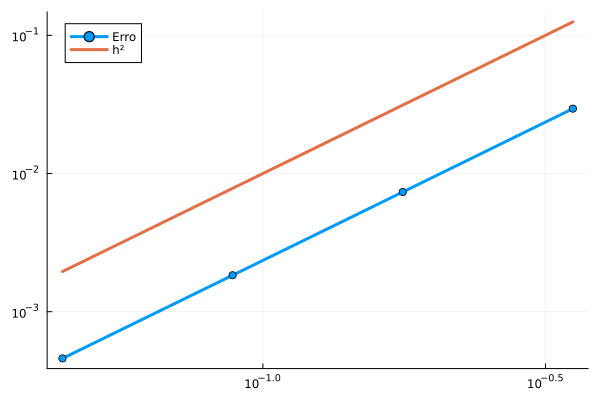

In [48]:
plot_error_curves(resultado_convergencia_quad[: ,:1], resultado_convergencia_quad[: ,:2])

### Estudo 2 - Malha não-uniforme

In [49]:
α = 1.0
β = 1.0
f = (x₁::Float64, x₂::Float64) -> (2*α*π^2+β) * sin(π*x₁) * sin(π*x₂)
u = (x₁::Float64, x₂::Float64) -> sin(π*x₁) * sin(π*x₂)
n_testes = 4

@time resultado_convergencia_quad = estudo_de_convergencia_quadrilatero(α, β, f, u, n_testes, true)

  9.581579 seconds (133.05 M allocations: 3.904 GiB, 3.75% gc time, 1.23% compilation time)


4×2 Matrix{Float64}:
 0.353553   0.0384008
 0.176777   0.0100688
 0.0883883  0.00247947
 0.0441942  0.00064066

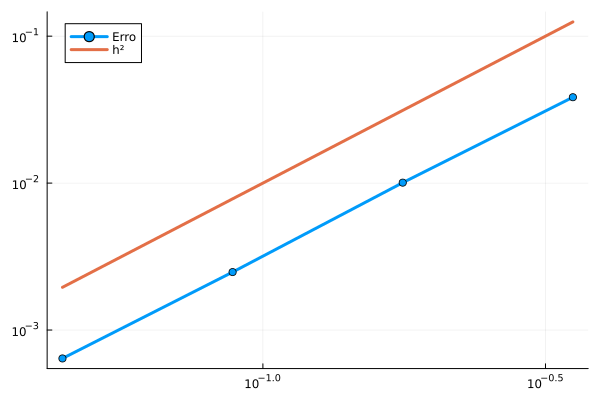

In [50]:
plot_error_curves(resultado_convergencia_quad[: ,:1], resultado_convergencia_quad[: ,:2])